In [1]:
#Import Libraries
import os
from glob import glob
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,confusion_matrix,classification_report

from keras.models import Sequential,Model
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
class_labels = ['Safe driving','Texting-right','Talking on the phone-right','Texting-left','Talking on the phone-left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']

In [3]:
#NW params
img_dims = 128
batch_size =32
nClasses=10
os.mkdir('saved_model')

In [4]:
#Function to read images and create a list of images and labels
def create_data(isTrain=True):
    
    if isTrain:
        print('Working on Train Directory')
        train_images=[]
        train_labels=[]
        
        for x in tqdm(range(nClasses)):
            print('Loading c{}...'.format(x))
            files = glob(os.path.join('..', 'input','state-farm-distracted-driver-detection','imgs','train', 'c' + str(x), '*.jpg'))
            for file in files:
                img = cv2.imread(file, cv2.IMREAD_COLOR)
                img=cv2.resize(img,(img_dims,img_dims))
                train_images.append(img)
                train_labels.append(x)
            print('c{} done'.format(x))
        print('Loading Train Directory complete...')
        return train_images, train_labels
    
    else:
        print('Working on Test Directory')
        test_images =[]
        test_id=[]
        files = glob(os.path.join('..', 'input','state-farm-distracted-driver-detection','imgs','test', '*.jpg'))
        for file in tqdm(files):
            img = cv2.imread(file, cv2.IMREAD_COLOR)
            img = cv2.resize(img,(img_dims,img_dims))
            test_images.append(img)
            test_id.append(os.path.basename(file))
        print('Loading Test Directory complete...')
        return test_images, test_id          

In [5]:
# plt.imshow(img_t[0],interpolation = 'bicubic')
# plt.title(img_l[0])
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()

In [6]:
#Function to create train/test data
def create_train_test(isTrain=True):
    
    if isTrain:
        X,labels  = create_data(isTrain=True)
        y = np_utils.to_categorical(labels,10)
        x_train, x_test, y_train, y_test = train_test_split(X, y)
        x_train = np.array(x_train, dtype = np.uint8).reshape(-1,img_dims,img_dims,3)
        x_test = np.array(x_test, dtype = np.uint8).reshape(-1,img_dims,img_dims,3)
        
        return x_train, x_test, y_train, y_test
    
    else:
        test_data, test_ids = create_data(isTrain=False)
        test_data = np.array(test_data,dtype = np.uint8).reshape(-1,img_dims,img_dims,3)
        return test_data,test_ids

In [7]:
#Create train data
x_train, x_test, y_train, y_test = create_train_test(isTrain = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Working on Train Directory
Loading c0...


 10%|█         | 1/10 [00:36<05:25, 36.16s/it]

c0 done
Loading c1...


 20%|██        | 2/10 [01:10<04:40, 35.06s/it]

c1 done
Loading c2...


 30%|███       | 3/10 [01:44<04:02, 34.69s/it]

c2 done
Loading c3...


 40%|████      | 4/10 [02:20<03:29, 34.93s/it]

c3 done
Loading c4...


 50%|█████     | 5/10 [02:55<02:56, 35.31s/it]

c4 done
Loading c5...


 60%|██████    | 6/10 [03:35<02:26, 36.68s/it]

c5 done
Loading c6...


 70%|███████   | 7/10 [04:10<01:48, 36.20s/it]

c6 done
Loading c7...


 80%|████████  | 8/10 [04:41<01:09, 34.63s/it]

c7 done
Loading c8...


 90%|█████████ | 9/10 [05:19<00:35, 35.65s/it]

c8 done
Loading c9...


100%|██████████| 10/10 [05:52<00:00, 35.26s/it]

c9 done
Loading Train Directory complete...


In [8]:
#Create test data
test_files,test_targets = create_train_test(isTrain=False)

Working on Test Directory


100%|██████████| 79726/79726 [18:08<00:00, 73.26it/s]  


Loading Test Directory complete...


In [9]:
#Check shapes
print('Train data shape:',x_train.shape)
print('Validation data shape:',x_test.shape)
print('Test data shape:',test_files.shape)

Train data shape: (16818, 128, 128, 3)
Validation data shape: (5606, 128, 128, 3)
Test data shape: (79726, 128, 128, 3)


In [10]:
print('Train data shape:',x_train[0].shape)

Train data shape: (128, 128, 3)


In [11]:
#Create callbacks
checkpoint = ModelCheckpoint(filepath = 'saved_model/best_weights.hdf5',
                            monitor='val_loss',
                            mode='min',
                            verbose=1,
                            save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy',
                         mode='max',
                         patience=3,
                         verbose=1,
                         restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                mode='min',
                                factor=0.2,
                                patience = 6,
                                verbose=1)
callbacks = [checkpoint,earlystop,lr_reduction]

In [12]:
#Create Model
def create_model():

    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_dims, img_dims, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [13]:
#Compile Model
model = create_model()
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
#Fit Model
history=model.fit(x_train, y_train,
                 validation_data=(x_test,y_test),
                 callbacks=callbacks,
                 epochs = 15,
                 batch_size = batch_size,
                 verbose = 1)

Epoch 1/15
526/526 [==============================] - 24s 35ms/step - loss: 1.5205 - accuracy: 0.5210 - val_loss: 0.1413 - val_accuracy: 0.9588

Epoch 00001: val_loss improved from inf to 0.14126, saving model to saved_model/best_weights.hdf5
Epoch 2/15
526/526 [==============================] - 18s 33ms/step - loss: 0.2544 - accuracy: 0.9212 - val_loss: 0.0828 - val_accuracy: 0.9754

Epoch 00002: val_loss improved from 0.14126 to 0.08283, saving model to saved_model/best_weights.hdf5
Epoch 3/15
526/526 [==============================] - 18s 33ms/step - loss: 0.1559 - accuracy: 0.9482 - val_loss: 0.1102 - val_accuracy: 0.9640

Epoch 00003: val_loss did not improve from 0.08283
Epoch 4/15
526/526 [==============================] - 17s 33ms/step - loss: 0.1091 - accuracy: 0.9660 - val_loss: 0.0846 - val_accuracy: 0.9761

Epoch 00004: val_loss did not improve from 0.08283
Epoch 5/15
526/526 [==============================] - 17s 33ms/step - loss: 0.0890 - accuracy: 0.9730 - val_loss: 0.09

In [15]:
#Score Model
score = model.evaluate(x_test,y_test,verbose =1)
print('Test Loss:',score[0])
print('Test Accuracy:',score[1])
y_pred=model.predict(x_test,batch_size =batch_size)
log_score = log_loss(y_test,y_pred)
print('Test Log Loss:', log_score)

176/176 [==============================] - 2s 9ms/step - loss: 0.0401 - accuracy: 0.9950
Test Loss: 0.04014171287417412
Test Accuracy: 0.9950053691864014
Test Log Loss: 0.03525932402215034


In [16]:
#Report Model
df_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
df_preds = pd.DataFrame(y_pred).idxmax(axis=1)
print(classification_report(df_test_labels, df_preds,target_names=class_labels))
print(confusion_matrix(df_test_labels, df_preds))

                            precision    recall  f1-score   support

              Safe driving       1.00      1.00      1.00       649
             Texting-right       1.00      1.00      1.00       566
Talking on the phone-right       1.00      1.00      1.00       569
              Texting-left       0.99      1.00      1.00       567
 Talking on the phone-left       0.99      1.00      1.00       612
       Operating the radio       1.00      1.00      1.00       599
                  Drinking       0.99      0.99      0.99       543
           Reaching behind       1.00      0.99      1.00       488
           Hair and makeup       1.00      0.98      0.99       480
      Talking to passenger       0.99      0.99      0.99       533

                  accuracy                           1.00      5606
                 macro avg       0.99      0.99      0.99      5606
              weighted avg       1.00      1.00      1.00      5606

[[646   0   0   1   1   0   1   0   0   0]
 [

In [17]:
# rounded_predictions = np.argmax(y_pred, axis=-1)
# rounded_truth = np.argmax(y_test,axis=-1)
# confusion_matrix_2 = confusion_matrix(y_true=rounded_truth, y_pred=rounded_predictions)

In [18]:
# def plot_confusion_matrix(cm, classes,
#                         normalize=False,
#                         title='Confusion matrix',
#                         cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#             horizontalalignment="center",
#             color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [19]:
# df_cm = pd.DataFrame(confusion_matrix_1, columns=class_labels, index = class_labels)
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize = (10,10))
# sns.set(font_scale=1)#for label size
# sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10})

1/1 [==============================] - 0s 62ms/step
Predicted: Hair and makeup


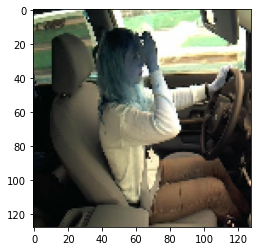

In [20]:
#Predict on test data
def plot_test_class(model, test_files, image_number, color_type=3):
    test_img = test_files[image_number]
    test_img = cv2.resize(test_img,(img_dims,img_dims))
    plt.imshow(test_img)
    new_img = test_img.reshape(-1,img_dims,img_dims,color_type)

    y_prediction_1 = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Predicted: {}'.format(class_labels[np.argmax(y_prediction_1)]))
    plt.grid(False)
    plt.show()
    
plot_test_class(model,test_files,0)

In [23]:
#Convert the model
saved_model_dir = './savedx/TFLite'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [24]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model_1.tflite', 'wb') as f:
#     f.write(tflite_model)